In [1]:
!pip install torch torchvision pycocotools tqdm pillow 
!apt install tree -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
# Célula 2 (VERIFIQUE SE ESTÁ ASSIM)

# Importar bibliotecas
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_MobileNet_V3_Large_FPN_Weights
from torchvision.datasets import CocoDetection
from torch.utils.data import Dataset, DataLoader
import os
from torchmetrics.detection import MeanAveragePrecision
import torchvision.transforms.v2 as T
from PIL import Image
from tqdm import tqdm

In [3]:
LOCAL_DATASET_PATH = "/kaggle/input/robocup-coco"

# (Opcional) Mostra a estrutura descompactada
!tree -L 3 "{LOCAL_DATASET_PATH}"

/kaggle/input/robocup-coco
└── robocup_coco
    ├── README.dataset.txt
    ├── README.roboflow.txt
    ├── test
    │   ├── _annotations.coco.json
    │   └── Imagens
    ├── train
    │   ├── _annotations.coco.json
    │   └── Imagens
    └── valid
        ├── _annotations.coco.json
        └── Imagens

7 directories, 5 files


In [4]:
# Configurações
DATASET_PATH = LOCAL_DATASET_PATH + "/robocup_coco"
NUM_EPOCHS = 30
BATCH_SIZE = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Usando o dispositivo: {DEVICE}")

# Configurações checkpointing
# Para Colab (aponte para seu Google Drive):
# CHECKPOINT_DIR = "/content/drive/MyDrive/UFU/MSc. 2025-2/Top IA - Análise de Imagem e Vídeo/Colab/Trabalho Final/mobilenet_fasterrcnn_checkpoint"
# Para Kaggle (use o diretório de trabalho):
CHECKPOINT_DIR = "/kaggle/working/mobilenet_fasterrcnn_checkpoint"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "checkpoint.pth")
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_model.pth")
print(f"Checkpoints serão salvos em: {CHECKPOINT_DIR}")

Usando o dispositivo: cuda
Checkpoints serão salvos em: /kaggle/working/mobilenet_fasterrcnn_checkpoint


In [5]:
# Criar modelo
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT)

    # Obter o número de características de entrada para o classificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Substituir a "cabeça" do classificador pré-treinada por uma nova
    # num_classes inclui a classe de fundo (background)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [6]:
# 1. Onde seu script de treino espera que os checkpoints estejam
# (Este caminho DEVE ser o mesmo da Célula 5)
KAGGLE_WORKING_DIR = CHECKPOINT_DIR # CHECKPOINT_DIR já foi definido na Célula 5

# 2. Onde o Kaggle montou seu Dataset de checkpoints
# (Mude 'robocup-mobilenet-checkpoint' se você deu um nome diferente)
INPUT_CHECKPOINT_DIR = "/kaggle/input/mobilenet-fasterrcnn-checkpoint-collab"

# 3. Os arquivos que queremos copiar
CHECKPOINT_FILE = "checkpoint.pth"
BEST_MODEL_FILE = "best_model.pth"

# 4. Copia os arquivos
print("Copiando checkpoints pré-treinados do Kaggle Input para o Kaggle Working...")

# Copia o checkpoint principal
src_path = os.path.join(INPUT_CHECKPOINT_DIR, CHECKPOINT_FILE)
dst_path = os.path.join(KAGGLE_WORKING_DIR, CHECKPOINT_FILE)
if os.path.exists(src_path):
    !cp "{src_path}" "{dst_path}"
    print(f"Arquivo {CHECKPOINT_FILE} copiado.")
else:
    print(f"Aviso: {CHECKPOINT_FILE} não encontrado em {INPUT_CHECKPOINT_DIR}")

# Copia o 'best_model.pth' para que 'best_map' seja carregado corretamente
src_path_best = os.path.join(INPUT_CHECKPOINT_DIR, BEST_MODEL_FILE)
dst_path_best = os.path.join(KAGGLE_WORKING_DIR, BEST_MODEL_FILE)
if os.path.exists(src_path_best):
    !cp "{src_path_best}" "{dst_path_best}"
    print(f"Arquivo {BEST_MODEL_FILE} copiado.")

print("Cópia concluída. Verificando arquivos:")
!ls -l "{KAGGLE_WORKING_DIR}"

Copiando checkpoints pré-treinados do Kaggle Input para o Kaggle Working...
Arquivo checkpoint.pth copiado.
Arquivo best_model.pth copiado.
Cópia concluída. Verificando arquivos:
total 223236
-rw-r--r-- 1 root root  76367047 Oct 19 03:41 best_model.pth
-rw-r--r-- 1 root root 152222651 Oct 19 03:41 checkpoint.pth


In [7]:
def get_transform(train):
    """Define as transformações/data augmentation."""
    transforms = []
    transforms.append(T.ToImage())
    transforms.append(T.ToDtype(torch.float, scale=True)) # Converte para float e normaliza para [0,1]
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# Necessária porque, em detecção de objetos, os dados dentro de um lote (batch)
# não têm o mesmo tamanho (são "irregulares": imagens com tamanhos diferentes, nro. de boxes diferentes).
def collate_fn(batch):
    """
    Função 'collate' para o DataLoader, para lidar com lotes de dados.
    Lógica personalizada para criar um batch.
    """
    return tuple(zip(*batch))

In [8]:
class RobocupCocoDataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None, junk_category_name=None):
        # 1. Inicializa a classe CocoDetection
        # Não passa as transformações para o 'super' ainda,
        # pois as aplicaremos manualmente no final
        super().__init__(root, annFile)

        # 2. Armazena as transformações
        self.transforms = transforms

        # 3. Aplica o patch (remove junk classes)
        if junk_category_name:
            print(f"Iniciando 'patch' do dataset para remover '{junk_category_name}'...")
            self._patch_dataset(junk_category_name)
            print("Patch concluído.")

    def _patch_dataset(self, junk_category_name):
        junk_cat_id = None
        for cat_id, cat_info in list(self.coco.cats.items()):
            if cat_info['name'] == junk_category_name:
                junk_cat_id = cat_id
                del self.coco.cats[cat_id]
                break

        if junk_cat_id is None:
            print(f"Aviso: Categoria '{junk_category_name}' não encontrada.")
            return

        print(f"Categoria 'junk' encontrada com ID: {junk_cat_id}. Removendo...")
        anns_to_remove = []
        for ann_id, ann in self.coco.anns.items():
            if ann['category_id'] == junk_cat_id:
                anns_to_remove.append(ann_id)

        for ann_id in anns_to_remove:
            del self.coco.anns[ann_id]

        for img_id, ann_ids in self.coco.imgToAnns.items():
            self.coco.imgToAnns[img_id] = [ann_id for ann_id in ann_ids if ann_id not in anns_to_remove]

        original_image_count = len(self.ids)
        self.ids = [img_id for img_id in self.ids if len(self.coco.imgToAnns[img_id]) > 0]
        new_image_count = len(self.ids)

        print(f"{len(anns_to_remove)} anotações 'junk' removidas.")
        print(f"{original_image_count - new_image_count} imagens removidas por ficarem vazias.")

    def __getitem__(self, index):
        # 1. Pega os dados brutos usando a lógica interna do CocoDetection
        img_id = self.ids[index]
        image = self._load_image(img_id)      # Carrega a Imagem PIL
        target_list = self._load_target(img_id) # Carrega a LISTA de anotações

        # 2. Converte a lista de anotações (target_list) no dicionário (target_dict)
        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for ann in target_list:
            # O formato COCO 'bbox' é [x, y, width, height]
            # O formato 'torchvision' 'boxes' é [x1, y1, x2, y2]
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            xmax = xmin + ann['bbox'][2]
            ymax = ymin + ann['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

            labels.append(ann['category_id'])
            areas.append(ann['area'])
            iscrowd.append(ann['iscrowd'])

        # 3. Converte para Tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        image_id = torch.tensor([img_id])

        # 4. Monta o dicionário de target final
        target_dict = {}
        target_dict["boxes"] = boxes
        target_dict["labels"] = labels
        target_dict["image_id"] = image_id
        target_dict["area"] = areas
        target_dict["iscrowd"] = iscrowd

        # 5. Aplica as transformações (agora elas recebem a img e o target_dict)
        if self.transforms is not None:
            image, target_dict = self.transforms(image, target_dict)

        return image, target_dict

# Treinamento

In [9]:
# Caminhos para os conjuntos de treino e validação
train_dir = os.path.join(DATASET_PATH, "train")
valid_dir = os.path.join(DATASET_PATH, "valid")

# Caminhos específicos para imagens e anotações de TREINO
train_img_dir = os.path.join(train_dir, "Imagens")
train_ann_file = os.path.join(train_dir, "_annotations.coco.json")

# Caminhos específicos para imagens e anotações de VALIDAÇÃO
valid_img_dir = os.path.join(valid_dir, "Imagens")
valid_ann_file = os.path.join(valid_dir, "_annotations.coco.json")

JUNK_NAME = 'Axis2-Bearing2-Housing-Motor2-FRQP'

# 1. Criar o Dataset de Treino
train_dataset = RobocupCocoDataset(
    root=train_img_dir,
    annFile=train_ann_file,
    transforms=get_transform(train=True),
    junk_category_name=JUNK_NAME
)

# 2. Criar o Dataset de Validação
valid_dataset = RobocupCocoDataset(
    root=valid_img_dir,
    annFile=valid_ann_file,
    transforms=get_transform(train=False),
    junk_category_name=JUNK_NAME
)

print(f"Dataset de treino carregado com {len(train_dataset)} imagens.")
print(f"Dataset de validação carregado com {len(valid_dataset)} imagens.")

num_classes_from_dataset = len(train_dataset.coco.cats)
NUM_CLASSES = num_classes_from_dataset + 1 # +1 para o background
print(f"Número de classes detectado: {num_classes_from_dataset} (+1 background = {NUM_CLASSES})")

# Criando o mapa de classes para usar na inferência (opcional, mas útil)
CLASS_NAMES = {cat_id: info['name'] for cat_id, info in train_dataset.coco.cats.items()}

print("Categorias: ")
print(train_dataset.coco.cats)
model_class_map = {i: cat['name'] for i, cat in train_dataset.coco.cats.items()}
print("Mapa de classes para o modelo:")
print(model_class_map)

# --- DATALOADERS ---
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn
)

loading annotations into memory...
Done (t=1.17s)
creating index...
index created!
Iniciando 'patch' do dataset para remover 'Axis2-Bearing2-Housing-Motor2-FRQP'...
Categoria 'junk' encontrada com ID: 0. Removendo...
0 anotações 'junk' removidas.
1960 imagens removidas por ficarem vazias.
Patch concluído.
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Iniciando 'patch' do dataset para remover 'Axis2-Bearing2-Housing-Motor2-FRQP'...
Categoria 'junk' encontrada com ID: 0. Removendo...
0 anotações 'junk' removidas.
98 imagens removidas por ficarem vazias.
Patch concluído.
Dataset de treino carregado com 32489 imagens.
Dataset de validação carregado com 1628 imagens.
Número de classes detectado: 18 (+1 background = 19)
Categorias: 
{1: {'id': 1, 'name': 'AllenKey', 'supercategory': 'Axis2-Bearing2-Housing-Motor2-FRQP'}, 2: {'id': 2, 'name': 'Axis2', 'supercategory': 'Axis2-Bearing2-Housing-Motor2-FRQP'}, 3: {'id': 3, 'name': 'Bearing2', 'supercategory': 

In [10]:
# Defina o número de classes (suas classes + 1 para o fundo)
model = get_model(NUM_CLASSES)

# Mover o modelo para a GPU, se disponível
model.to(DEVICE)

# Definir otimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Agendador de taxa de aprendizado
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 68.4MB/s]


In [11]:
# --- LÓGICA PARA CARREGAR O CHECKPOINT (RESUMIR) ---
start_epoch = 0
best_map = 0.0

# Inicializa listas para armazenar o histórico
train_loss_history = []
val_map_history = []

if os.path.exists(CHECKPOINT_PATH):
    print(f"Carregando checkpoint de '{CHECKPOINT_PATH}'...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 # Começa da *próxima* época
    best_map = checkpoint['best_map']

    # Carrega o histórico salvo para continuar
    if 'train_loss_history' in checkpoint:
        train_loss_history = checkpoint['train_loss_history']
    if 'val_map_history' in checkpoint:
        val_map_history = checkpoint['val_map_history']

    print(f"Checkpoint carregado. Resumindo da época {start_epoch}")
    print(f"Melhor mAP até agora: {best_map:.4f}")
else:
    print("Nenhum checkpoint encontrado. Começando treinamento do zero.")

Carregando checkpoint de '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'...
Checkpoint carregado. Resumindo da época 7
Melhor mAP até agora: 0.7729


In [12]:
# Loop de treinamento
for epoch in range(start_epoch, NUM_EPOCHS):
    model.train() # Coloca o modelo em modo de treinamento
    epoch_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Época {epoch+1}/{NUM_EPOCHS}", unit="batch")

    for images, targets in progress_bar:
        # Mover dados para o device correto
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # O modelo retorna um dicionário de perdas em modo de treino
        loss_dict = model(images, targets)

        # Somar todas as perdas
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        batch_loss = losses.item()
        epoch_loss += batch_loss
        progress_bar.set_postfix(loss=batch_loss)

    # Calcula e salva a perda da época
    train_loss = epoch_loss/len(train_loader)
    train_loss_history.append(train_loss)

    # Atualiza o agendador de taxa de aprendizado
    lr_scheduler.step()

    print(f"Época {epoch+1}/{NUM_EPOCHS}, Perda: {epoch_loss/len(train_loader)}")

    # --- VALIDAÇÃO (ESSENCIAL PARA SALVAR O MELHOR MODELO) ---
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for images, targets in valid_loader:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            predictions = model(images)
            metric.update(predictions, targets)

    val_metrics = metric.compute()
    val_map = val_metrics['map'].item() # Pega o mAP principal (IoU de 0.5 a 0.95)
    # Salva a métrica de validação da época
    val_map_history.append(val_map)

    # Imprime o dicionário completo de métricas
    print("Métricas de Validação:")
    for k, v in val_metrics.items():
        # 'v' é sempre um tensor. Verificamos se ele tem 1 elemento (escalar)
        if v.numel() == 1:
            # Se for escalar, usamos .item() e formatamos
            print(f"  {k}: {v.item():.4f}")
        else:
            # Se tiver >1 elemento (ex: as métricas 'per_class' de 18 elementos)
            # Apenas imprimimos o tensor. Não usamos .item()
            print(f"  {k}: {v}")


    print(f"Época {epoch+1}/{NUM_EPOCHS} - "
            f"Perda Treino: {train_loss:.4f} - "
            f"mAP Validação: {val_map:.4f}")
    # --- LÓGICA PARA SALVAR O CHECKPOINT ---

    # 1. Salvar o melhor modelo (para inferência futura)
    if val_map > best_map:
        best_map = val_map
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"Novo melhor modelo salvo com mAP: {best_map:.4f} em '{BEST_MODEL_PATH}'")

    # 2. Salvar o checkpoint da última época (para resumir)
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': lr_scheduler.state_dict(),
        'best_map': best_map,
        'train_loss_history': train_loss_history,
        'val_map_history': val_map_history
    }
    torch.save(checkpoint_data, CHECKPOINT_PATH)
    print(f"Checkpoint da época {epoch+1} salvo em '{CHECKPOINT_PATH}'")

print("Treinamento concluído.")

# Salvar o modelo treinado
torch.save(model.state_dict(), 'fasterrcnn_mobilenet_detector.pth')
print("Modelo salvo")

Época 8/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.42batch/s, loss=0.165]

Época 8/30, Perda: 0.3919404283813489


Métricas de Validação:
  map: 0.7659
  map_50: 0.9542
  map_75: 0.8969
  map_small: 0.6182
  map_medium: 0.7845
  map_large: 0.7103
  mar_1: 0.8138
  mar_10: 0.8384
  mar_100: 0.8384
  mar_small: 0.6794
  mar_medium: 0.8408
  mar_large: 0.8366
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 8/30 - Perda Treino: 0.3919 - mAP Validação: 0.7659
Checkpoint da época 8 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 9/30: 100%|██████████| 8123/8123 [25:03<00:00,  5.40batch/s, loss=0.142]

Época 9/30, Perda: 0.3875507278207134


Métricas de Validação:
  map: 0.7814
  map_50: 0.9665
  map_75: 0.9112
  map_small: 0.6189
  map_medium: 0.7976
  map_large: 0.7410
  mar_1: 0.8206
  mar_10: 0.8423
  mar_100: 0.8423
  mar_small: 0.6745
  mar_medium: 0.8474
  mar_large: 0.8492
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 9/30 - Perda Treino: 0.3876 - mAP Validação: 0.7814
Novo melhor modelo salvo com mAP: 0.7814 em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/best_model.pth'
Checkpoint da época 9 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 10/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.41batch/s, loss=0.596]

Época 10/30, Perda: 0.38929441288089744


Métricas de Validação:
  map: 0.7711
  map_50: 0.9579
  map_75: 0.9030
  map_small: 0.6163
  map_medium: 0.7946
  map_large: 0.7156
  mar_1: 0.8160
  mar_10: 0.8404
  mar_100: 0.8404
  mar_small: 0.6780
  mar_medium: 0.8477
  mar_large: 0.8371
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 10/30 - Perda Treino: 0.3893 - mAP Validação: 0.7711
Checkpoint da época 10 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 11/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.41batch/s, loss=0.956]

Época 11/30, Perda: 0.38707267464942624


Métricas de Validação:
  map: 0.7709
  map_50: 0.9573
  map_75: 0.9009
  map_small: 0.6162
  map_medium: 0.7927
  map_large: 0.7120
  mar_1: 0.8159
  mar_10: 0.8402
  mar_100: 0.8402
  mar_small: 0.6775
  mar_medium: 0.8456
  mar_large: 0.8347
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 11/30 - Perda Treino: 0.3871 - mAP Validação: 0.7709
Checkpoint da época 11 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 12/30: 100%|██████████| 8123/8123 [24:58<00:00,  5.42batch/s, loss=0.494]

Época 12/30, Perda: 0.38658700306640387


Métricas de Validação:
  map: 0.7732
  map_50: 0.9593
  map_75: 0.9032
  map_small: 0.6166
  map_medium: 0.7948
  map_large: 0.7202
  mar_1: 0.8166
  mar_10: 0.8406
  mar_100: 0.8406
  mar_small: 0.6775
  mar_medium: 0.8469
  mar_large: 0.8394
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 12/30 - Perda Treino: 0.3866 - mAP Validação: 0.7732
Checkpoint da época 12 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 13/30: 100%|██████████| 8123/8123 [24:59<00:00,  5.42batch/s, loss=0.605]

Época 13/30, Perda: 0.38676164562767046


Métricas de Validação:
  map: 0.7709
  map_50: 0.9569
  map_75: 0.9015
  map_small: 0.6177
  map_medium: 0.7939
  map_large: 0.7163
  mar_1: 0.8161
  mar_10: 0.8404
  mar_100: 0.8404
  mar_small: 0.6787
  mar_medium: 0.8471
  mar_large: 0.8380
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 13/30 - Perda Treino: 0.3868 - mAP Validação: 0.7709
Checkpoint da época 13 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 14/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.41batch/s, loss=0.417]

Época 14/30, Perda: 0.38564682326395494


Métricas de Validação:
  map: 0.7717
  map_50: 0.9576
  map_75: 0.9018
  map_small: 0.6165
  map_medium: 0.7945
  map_large: 0.7178
  mar_1: 0.8165
  mar_10: 0.8406
  mar_100: 0.8406
  mar_small: 0.6787
  mar_medium: 0.8473
  mar_large: 0.8388
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 14/30 - Perda Treino: 0.3856 - mAP Validação: 0.7717
Checkpoint da época 14 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 15/30: 100%|██████████| 8123/8123 [25:02<00:00,  5.41batch/s, loss=0.496]

Época 15/30, Perda: 0.38762651418272565


Métricas de Validação:
  map: 0.7710
  map_50: 0.9570
  map_75: 0.9017
  map_small: 0.6172
  map_medium: 0.7943
  map_large: 0.7157
  mar_1: 0.8161
  mar_10: 0.8404
  mar_100: 0.8404
  mar_small: 0.6783
  mar_medium: 0.8474
  mar_large: 0.8378
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 15/30 - Perda Treino: 0.3876 - mAP Validação: 0.7710
Checkpoint da época 15 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 16/30: 100%|██████████| 8123/8123 [25:02<00:00,  5.41batch/s, loss=0.281]

Época 16/30, Perda: 0.3865022512087898


Métricas de Validação:
  map: 0.7710
  map_50: 0.9571
  map_75: 0.9017
  map_small: 0.6175
  map_medium: 0.7942
  map_large: 0.7161
  mar_1: 0.8161
  mar_10: 0.8404
  mar_100: 0.8404
  mar_small: 0.6786
  mar_medium: 0.8472
  mar_large: 0.8382
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 16/30 - Perda Treino: 0.3865 - mAP Validação: 0.7710
Checkpoint da época 16 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 17/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.41batch/s, loss=0.264]

Época 17/30, Perda: 0.3848112031549608


Métricas de Validação:
  map: 0.7710
  map_50: 0.9571
  map_75: 0.9017
  map_small: 0.6175
  map_medium: 0.7942
  map_large: 0.7161
  mar_1: 0.8160
  mar_10: 0.8404
  mar_100: 0.8404
  mar_small: 0.6786
  mar_medium: 0.8472
  mar_large: 0.8382
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 17/30 - Perda Treino: 0.3848 - mAP Validação: 0.7710
Checkpoint da época 17 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 18/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.41batch/s, loss=0.675]

Época 18/30, Perda: 0.38430279558087665


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 18/30 - Perda Treino: 0.3843 - mAP Validação: 0.7713
Checkpoint da época 18 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 19/30: 100%|██████████| 8123/8123 [25:03<00:00,  5.40batch/s, loss=0.541]

Época 19/30, Perda: 0.38592572367706424


Métricas de Validação:
  map: 0.7712
  map_50: 0.9575
  map_75: 0.9019
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7171
  mar_1: 0.8160
  mar_10: 0.8404
  mar_100: 0.8404
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 19/30 - Perda Treino: 0.3859 - mAP Validação: 0.7712
Checkpoint da época 19 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 20/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.41batch/s, loss=0.166]

Época 20/30, Perda: 0.3851686374791206


Métricas de Validação:
  map: 0.7712
  map_50: 0.9575
  map_75: 0.9019
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7171
  mar_1: 0.8160
  mar_10: 0.8404
  mar_100: 0.8404
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 20/30 - Perda Treino: 0.3852 - mAP Validação: 0.7712
Checkpoint da época 20 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 21/30: 100%|██████████| 8123/8123 [25:01<00:00,  5.41batch/s, loss=0.285]

Época 21/30, Perda: 0.3862064829325274


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 21/30 - Perda Treino: 0.3862 - mAP Validação: 0.7713
Checkpoint da época 21 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 22/30: 100%|██████████| 8123/8123 [25:01<00:00,  5.41batch/s, loss=0.241]

Época 22/30, Perda: 0.3863798530386408


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 22/30 - Perda Treino: 0.3864 - mAP Validação: 0.7713
Checkpoint da época 22 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 23/30: 100%|██████████| 8123/8123 [24:59<00:00,  5.42batch/s, loss=0.113]

Época 23/30, Perda: 0.38630720701150734


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 23/30 - Perda Treino: 0.3863 - mAP Validação: 0.7713
Checkpoint da época 23 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 24/30: 100%|██████████| 8123/8123 [25:00<00:00,  5.41batch/s, loss=0.461]

Época 24/30, Perda: 0.38539833269227275


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 24/30 - Perda Treino: 0.3854 - mAP Validação: 0.7713
Checkpoint da época 24 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 25/30: 100%|██████████| 8123/8123 [25:02<00:00,  5.40batch/s, loss=0.6]

Época 25/30, Perda: 0.3878698564316492


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 25/30 - Perda Treino: 0.3879 - mAP Validação: 0.7713
Checkpoint da época 25 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 26/30: 100%|██████████| 8123/8123 [25:02<00:00,  5.41batch/s, loss=0.114]

Época 26/30, Perda: 0.38645791668166496


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 26/30 - Perda Treino: 0.3865 - mAP Validação: 0.7713
Checkpoint da época 26 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 27/30: 100%|██████████| 8123/8123 [25:01<00:00,  5.41batch/s, loss=0.17]

Época 27/30, Perda: 0.3864735309257012


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 27/30 - Perda Treino: 0.3865 - mAP Validação: 0.7713
Checkpoint da época 27 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 28/30: 100%|██████████| 8123/8123 [24:58<00:00,  5.42batch/s, loss=0.084]

Época 28/30, Perda: 0.38834544234817053


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 28/30 - Perda Treino: 0.3883 - mAP Validação: 0.7713
Checkpoint da época 28 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 29/30: 100%|██████████| 8123/8123 [25:04<00:00,  5.40batch/s, loss=0.197]

Época 29/30, Perda: 0.3863752547747379


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 29/30 - Perda Treino: 0.3864 - mAP Validação: 0.7713
Checkpoint da época 29 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'


Época 30/30: 100%|██████████| 8123/8123 [25:02<00:00,  5.41batch/s, loss=0.333]

Época 30/30, Perda: 0.3859300860328201


Métricas de Validação:
  map: 0.7713
  map_50: 0.9575
  map_75: 0.9030
  map_small: 0.6175
  map_medium: 0.7944
  map_large: 0.7172
  mar_1: 0.8161
  mar_10: 0.8405
  mar_100: 0.8405
  mar_small: 0.6787
  mar_medium: 0.8472
  mar_large: 0.8383
  map_per_class: -1.0000
  mar_100_per_class: -1.0000
  classes: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
       dtype=torch.int32)
Época 30/30 - Perda Treino: 0.3859 - mAP Validação: 0.7713
Checkpoint da época 30 salvo em '/kaggle/working/mobilenet_fasterrcnn_checkpoint/checkpoint.pth'
Treinamento concluído.
Modelo salvo


# Inferência (e FPS)

In [13]:
import time

# --- Carregar o MELHOR modelo salvo ---
print(f"Carregando o melhor modelo de '{BEST_MODEL_PATH}' para medição de FPS...")
# 1. Recriar a arquitetura do modelo
model = get_model(NUM_CLASSES)

# 2. Carregar os pesos salvos
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval() # MUITO IMPORTANTE: colocar em modo de avaliação

print("Modelo carregado. Iniciando medição de FPS...")

# --- Loop de Medição ---
# Usaremos o valid_loader, mas sem calcular métricas, apenas o tempo
total_time = 0
image_count = 0
inference_loader = DataLoader(
    valid_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn
)

with torch.no_grad():
    for images, targets in inference_loader:
        images = list(image.to(DEVICE) for image in images)

        # Sincroniza a GPU para uma medição de tempo precisa (se estiver usando cuda)
        if DEVICE.type == 'cuda':
            torch.cuda.synchronize()

        start_time = time.time()

        # Apenas executa a inferência
        predictions = model(images)

        if DEVICE.type == 'cuda':
            torch.cuda.synchronize()

        end_time = time.time()

        total_time += (end_time - start_time)
        image_count += len(images)

# --- Calcular Resultados ---
avg_inference_time = total_time / image_count
fps = 1.0 / avg_inference_time

print("--- Resultados de Performance ---")
print(f"Total de imagens processadas: {image_count}")
print(f"Tempo total de inferência: {total_time:.2f} segundos")
print(f"Tempo médio por imagem: {avg_inference_time * 1000:.2f} ms") # Converte para milissegundos
print(f"FPS (Frames Per Second): {fps:.2f}")

Carregando o melhor modelo de '/kaggle/working/mobilenet_fasterrcnn_checkpoint/best_model.pth' para medição de FPS...
Modelo carregado. Iniciando medição de FPS...
--- Resultados de Performance ---
Total de imagens processadas: 1628
Tempo total de inferência: 38.26 segundos
Tempo médio por imagem: 23.50 ms
FPS (Frames Per Second): 42.55


# Gráficos

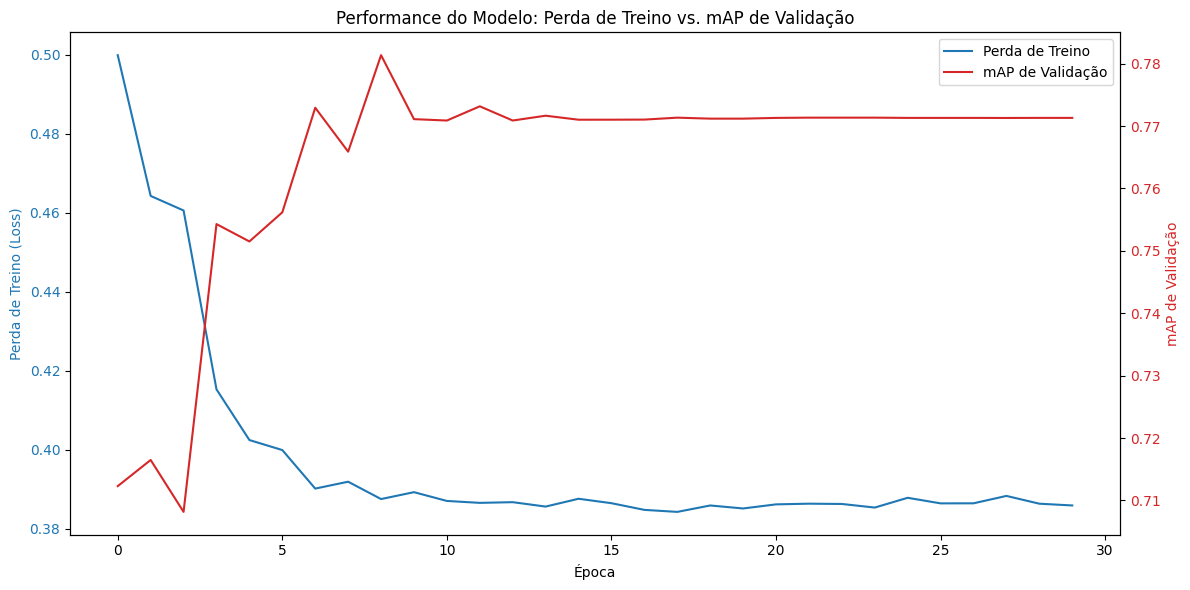

In [14]:
import matplotlib.pyplot as plt

# Carrega o checkpoint final para garantir que temos o histórico completo
# (Mesmo que o treinamento tenha acabado de rodar, é uma boa prática)
final_checkpoint = torch.load(CHECKPOINT_PATH)
loss_hist = final_checkpoint['train_loss_history']
map_hist = final_checkpoint['val_map_history']

# Cria a figura e o primeiro eixo (Perda de Treino)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot da Perda de Treino
color = 'tab:blue'
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda de Treino (Loss)', color=color)
ax1.plot(loss_hist, color=color, label='Perda de Treino')
ax1.tick_params(axis='y', labelcolor=color)

# Cria o segundo eixo (mAP de Validação) que compartilha o eixo x
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('mAP de Validação', color=color)
ax2.plot(map_hist, color=color, label='mAP de Validação')
ax2.tick_params(axis='y', labelcolor=color)

# Título e legenda
plt.title('Performance do Modelo: Perda de Treino vs. mAP de Validação')
fig.tight_layout()
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Salva o gráfico no seu Drive
plt.savefig(os.path.join(CHECKPOINT_DIR, "loss_vs_map_plot.png"))
plt.show()